In [44]:
import pandas as pd
import numpy as np
from trino import dbapi
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import time

In [45]:
# 1. Generate some new test data using DataFrame

start_time = time.time()

length = 1000

# Generate timestamps
start_date = datetime(2023, 1, 1)
dates = [start_date + timedelta(minutes=i) for i in range(length)]

# Generate sensor data
np.random.seed(42)
data = pd.DataFrame({
    'timestamp': dates,
    'sensor_key': np.random.choice(['SENSOR001', 'SENSOR002', 'SENSOR003'], length),
    'measurement_key': np.random.choice(['TEMPERATURE', 'HUMIDITY', 'PRESSURE'], length),
    'distance': np.random.uniform(1, 10, length),
    'value': np.random.normal(50, 10, length)
})

data_generation_time = time.time() - start_time
print(f"Data generation time: {data_generation_time:.2f} seconds")
print(data.head())

Data generation time: 0.02 seconds
            timestamp sensor_key measurement_key  distance      value
0 2023-01-01 00:00:00  SENSOR003        PRESSURE  5.231643  56.878633
1 2023-01-01 00:01:00  SENSOR001        PRESSURE  7.698512  54.196655
2 2023-01-01 00:02:00  SENSOR003        PRESSURE  8.846495  46.230048
3 2023-01-01 00:03:00  SENSOR003        PRESSURE  4.902898  55.757798
4 2023-01-01 00:04:00  SENSOR001     TEMPERATURE  1.392955  60.763720


In [46]:
# 2. Efficiently insert this data into F_SENSOR_DATA_DISTRIBUTED

# Connect to Trino
conn = dbapi.connect(
    host="trino",
    port=8080,
    user="jupyter",
    catalog="example",
    schema="silver",
)

# Create a cursor
cur = conn.cursor()

# Prepare the INSERT statement with multiple VALUES
values = [tuple(x) for x in data.values]
placeholders = ','.join(['(?, ?, ?, ?, ?)' for _ in values])
insert_query = f"""
INSERT INTO F_SENSOR_DATA_DISTRIBUTED (timestamp, sensor_key, measurement_key, distance, value)
VALUES {placeholders}
"""

# Flatten the list of tuples
flat_values = [item for sublist in values for item in sublist]

# Execute the INSERT statement with timing
start_time = time.time()
cur.execute(insert_query, flat_values)
insert_time = time.time() - start_time

print(f"Inserted {len(values)} rows into F_SENSOR_DATA_DISTRIBUTED")
print(f"Insert time: {insert_time:.2f} seconds")

Inserted 1000 rows into F_SENSOR_DATA_DISTRIBUTED
Insert time: 1.42 seconds


In [47]:
# 3. Query the data back

query = """
SELECT sensor_key, measurement_key, AVG(value) as avg_value
FROM F_SENSOR_DATA_DISTRIBUTED
GROUP BY sensor_key, measurement_key
"""

start_time = time.time()
cur.execute(query)
results = cur.fetchall()
query_time = time.time() - start_time

# Convert results to DataFrame
results_df = pd.DataFrame(results, columns=['sensor_key', 'measurement_key', 'avg_value'])
print(results_df)
print(f"Query execution time: {query_time:.2f} seconds")

  sensor_key measurement_key  avg_value
0  SENSOR003        HUMIDITY  51.664793
1  SENSOR002     TEMPERATURE  49.858267
2  SENSOR001        PRESSURE  49.561965
3  SENSOR001     TEMPERATURE  50.823252
4  SENSOR003        PRESSURE  54.371226
5  SENSOR002        HUMIDITY  49.704500
6  SENSOR003     TEMPERATURE  50.142730
7  SENSOR001        HUMIDITY  49.748193
8  SENSOR002        PRESSURE  51.089575
Query execution time: 0.90 seconds


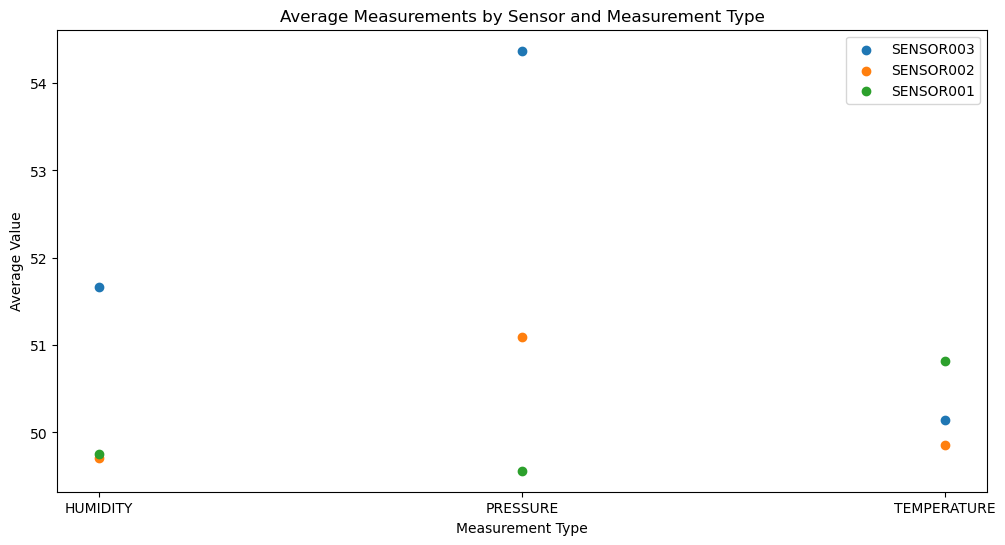

Plotting time: 0.11 seconds


In [51]:
# 4. Plot the data

start_time = time.time()

plt.figure(figsize=(12, 6))

for sensor in results_df['sensor_key'].unique():
    sensor_data = results_df[results_df['sensor_key'] == sensor]
    plt.scatter(sensor_data['measurement_key'], sensor_data['avg_value'], label=sensor)

plt.title('Average Measurements by Sensor and Measurement Type')
plt.xlabel('Measurement Type')
plt.ylabel('Average Value')
plt.legend()
plt.show()

plotting_time = time.time() - start_time
print(f"Plotting time: {plotting_time:.2f} seconds")

# Close the cursor and connection
cur.close()
conn.close()

In [49]:
# Print summary of execution times
print("\nExecution Time Summary:")
print(f"Data Generation: {data_generation_time:.2f} seconds")
print(f"Data Insertion: {insert_time:.2f} seconds")
print(f"Data Query: {query_time:.2f} seconds")
print(f"Data Plotting: {plotting_time:.2f} seconds")
print(f"Total Execution Time: {data_generation_time + insert_time + query_time + plotting_time:.2f} seconds")


Execution Time Summary:
Data Generation: 0.02 seconds
Data Insertion: 1.42 seconds
Data Query: 0.90 seconds
Data Plotting: 0.08 seconds
Total Execution Time: 2.42 seconds
